##Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Importing Libraries

In [ ]:
import numpy as np
import cv2
import keras
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Sequential,Model
from keras.layers import Activation,Dense,Flatten,Dropout,MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
import shutil as sh
import os
from keras.applications.xception import Xception
from PIL import Image
from keras.preprocessing import image
import tensorflow_datasets as tfds

##Importing dataset 

In [ ]:
filname = '/content/drive/MyDrive/Research Methodology/fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/MyDrive/Research Methodology/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


##Dividing Data into X and Y 

In [ ]:
def train_test(filname):
    Y = []
    X = []
    data = True
    for row in open(filname):
        if data:
            data = False
        else:
            train = row.split(',')
            Y.append(int(train[0]))
            X.append([int(p) for p in train[1].split()])

    X = np.array(X) / 255.0 
    Y = np.array(Y)
    return X, Y
    

In [ ]:
X, Y = train_test(filname)
num_class = len(set(Y))
print(num_class)

7


##Dividing Data into Train and Test 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

##Preprocessing Steps

In [ ]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 48, 48, 1))
X_test = np.reshape(X_test, (len(X_test), 48, 48, 1))

In [ ]:
train_images = tf.image.grayscale_to_rgb(
    (tf.convert_to_tensor(X_train, name=None))
    # name=None
)
# train_images = train_images / 255
print(train_images.shape)

(28709, 48, 48, 3)


In [ ]:
train_images = tf.image.resize(train_images, [128,128])

In [ ]:
test_images = tf.image.grayscale_to_rgb(
    (tf.convert_to_tensor(X_test, name=None))
    # name=None
)
print(test_images.shape)

(7178, 48, 48, 3)


In [ ]:
test_images = tf.image.resize(test_images, [128,128])

In [ ]:
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

##Loading the Pretrained Model MobileNet with Transfer learning ImageNet

In [ ]:
model = Sequential()
mobilenetmodel = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
model.add(mobilenetmodel)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(7,activation='softmax'))
adam = SGD(learning_rate=0.001, decay=1e-5, momentum=0.8, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc']) 

# data_train.fit(X_train)
history = model.fit(train_images,y_train, batch_size=32,epochs=10, validation_data=(test_images,y_test))
score= model.evaluate(test_images, y_test, batch_size=32,verbose=3)
print("test accuracy", score[1])  

Epoch 1/10
898/898 [==============================] - 96s 71ms/step - loss: 1.6255 - acc: 0.3990 - val_loss: 1.2918 - val_acc: 0.5145
Epoch 2/10
898/898 [==============================] - 61s 68ms/step - loss: 1.0673 - acc: 0.5990 - val_loss: 1.1595 - val_acc: 0.5591
Epoch 3/10
898/898 [==============================] - 61s 68ms/step - loss: 0.8504 - acc: 0.6821 - val_loss: 1.2221 - val_acc: 0.5485
Epoch 4/10
898/898 [==============================] - 62s 69ms/step - loss: 0.6708 - acc: 0.7577 - val_loss: 1.1407 - val_acc: 0.5882
Epoch 5/10
898/898 [==============================] - 61s 68ms/step - loss: 0.4943 - acc: 0.8219 - val_loss: 1.4603 - val_acc: 0.5189
Epoch 6/10
898/898 [==============================] - 63s 71ms/step - loss: 0.3558 - acc: 0.8749 - val_loss: 1.2994 - val_acc: 0.6046
Epoch 7/10
898/898 [==============================] - 61s 68ms/step - loss: 0.2523 - acc: 0.9133 - val_loss: 1.4525 - val_acc: 0.5952
Epoch 8/10
898/898 [==============================] - 61s 68ms

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 2160x2160 with 0 Axes>

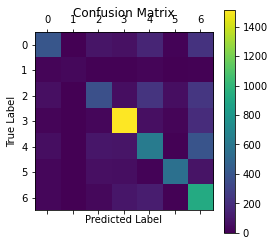

In [ ]:
from sklearn.metrics import confusion_matrix
results = model.predict_classes(test_images)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
plt.figure(figsize=(30, 30))
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##References
1) S. (2019, November 27). Facial Expression Detection (CNN). Kaggle. https://www.kaggle.com/shawon10/facial-expression-detection-cnn

2) J. (2019a, January 3). Face expression recognition with Deep Learning. Kaggle. https://www.kaggle.com/jonathanoheix face-expression-recognition-with-deep-learning

3) G. (2020, April 18). Facial Emotion Recognition. Kaggle. https://www.kaggle.com/gauravsharma99/facial-emotion-recognition

4) https://gist.github.com/Nabeel110/01210a28cbd8b53c13b42330abc253ad